In [21]:
import itertools

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import importlib
from numpy import fft
import fractional_differencing as fd
# importlib.reload(fd)
import pylab as pl

In [176]:
data=pd.read_csv("data_for_0p01s_time_slot.csv",index_col=0)['byteRates0p01']
data_train=data.iloc[:5000]
data_test=data.iloc[4800:]

In [177]:
data_train_fft=np.fft.fft(data_train)

In [19]:
data_train_fft

array([ 2.20908064e+12+0.00000000e+00j, -1.48228907e+09-4.28494903e+10j,
       -6.43023846e+09-1.18879906e+10j, ...,
        2.70454822e+10-1.10136746e+10j, -6.43023846e+09+1.18879906e+10j,
       -1.48228907e+09+4.28494903e+10j])

In [68]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 1000                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    



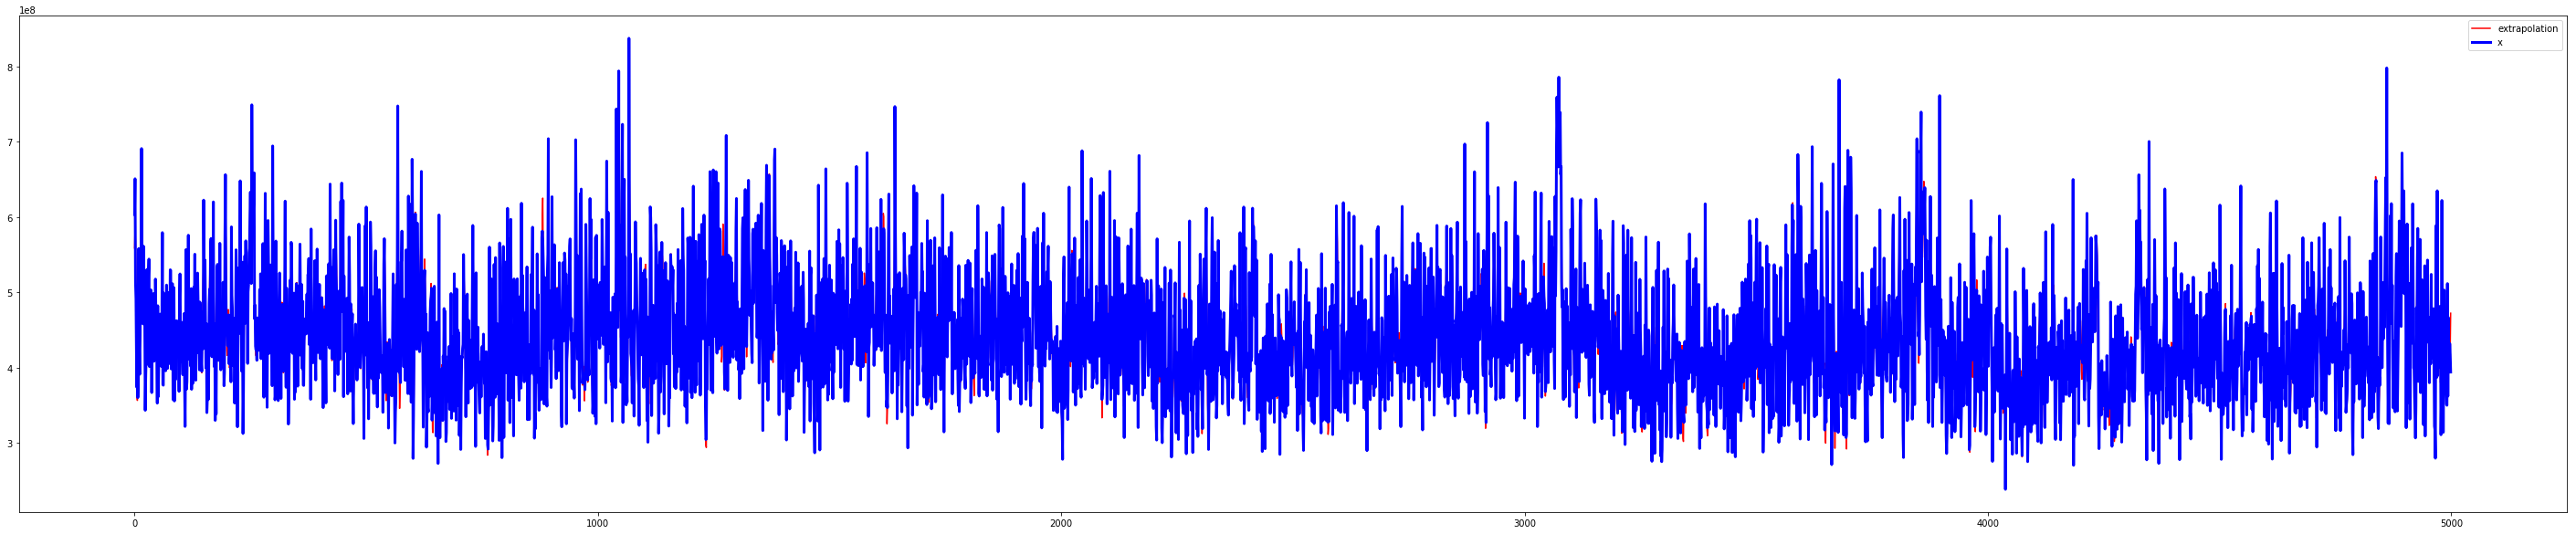

In [69]:
# x = np.array([669, 592, 664, 1005, 699, 401, 646, 472, 598, 681, 1126, 1260, 562, 491, 714, 530, 521, 687, 776, 802, 499, 536, 871, 801, 965, 768, 381, 497, 458, 699, 549, 427, 358, 219, 635, 756, 775, 969, 598, 630, 649, 722, 835, 812, 724, 966, 778, 584, 697, 737, 777, 1059, 1218, 848, 713, 884, 879, 1056, 1273, 1848, 780, 1206, 1404, 1444, 1412, 1493, 1576, 1178, 836, 1087, 1101, 1082, 775, 698, 620, 651, 731, 906, 958, 1039, 1105, 620, 576, 707, 888, 1052, 1072, 1357, 768, 986, 816, 889, 973, 983, 1351, 1266, 1053, 1879, 2085, 2419, 1880, 2045, 2212, 1491, 1378, 1524, 1231, 1577, 2459, 1848, 1506, 1589, 1386, 1111, 1180, 1075, 1595, 1309, 2092, 1846, 2321, 2036, 3587, 1637, 1416, 1432, 1110, 1135, 1233, 1439, 894, 628, 967, 1176, 1069, 1193, 1771, 1199, 888, 1155, 1254, 1403, 1502, 1692, 1187, 1110, 1382, 1808, 2039, 1810, 1819, 1408, 803, 1568, 1227, 1270, 1268, 1535, 873, 1006, 1328, 1733, 1352, 1906, 2029, 1734, 1314, 1810, 1540, 1958, 1420, 1530, 1126, 721, 771, 874, 997, 1186, 1415, 973, 1146, 1147, 1079, 3854, 3407, 2257, 1200, 734, 1051, 1030, 1370, 2422, 1531, 1062, 530, 1030, 1061, 1249, 2080, 2251, 1190, 756, 1161, 1053, 1063, 932, 1604, 1130, 744, 930, 948, 1107, 1161, 1194, 1366, 1155, 785, 602, 903, 1142, 1410, 1256, 742, 985, 1037, 1067, 1196, 1412, 1127, 779, 911, 989, 946, 888, 1349, 1124, 761, 994, 1068, 971, 1157, 1558, 1223, 782, 2790, 1835, 1444, 1098, 1399, 1255, 950, 1110, 1345, 1224, 1092, 1446, 1210, 1122, 1259, 1181, 1035, 1325, 1481, 1278, 769, 911, 876, 877, 950, 1383, 980, 705, 888, 877, 638, 1065, 1142, 1090, 1316, 1270, 1048, 1256, 1009, 1175, 1176, 870, 856, 860])
plt.figure(figsize=(50,10))
# n_predict = 1000
extrapolation = fourierExtrapolation(data_train, 0)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
pl.plot(np.arange(0, data_train.size), data_train, 'b', label = 'x', linewidth = 3)
pl.legend()
pl.show()

In [70]:
def tsplot(y, lags=None, title='', figsize=(10, 15)):
    
    fig = plt.figure(figsize=figsize)

    ts_ax   = plt.subplot(4,1,1)
    hist_ax = plt.subplot(4,1,2)
    acf_ax  = plt.subplot(4,1,3)
    pacf_ax = plt.subplot(4,1,4)
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x246e15d2978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246e164e0f0>)

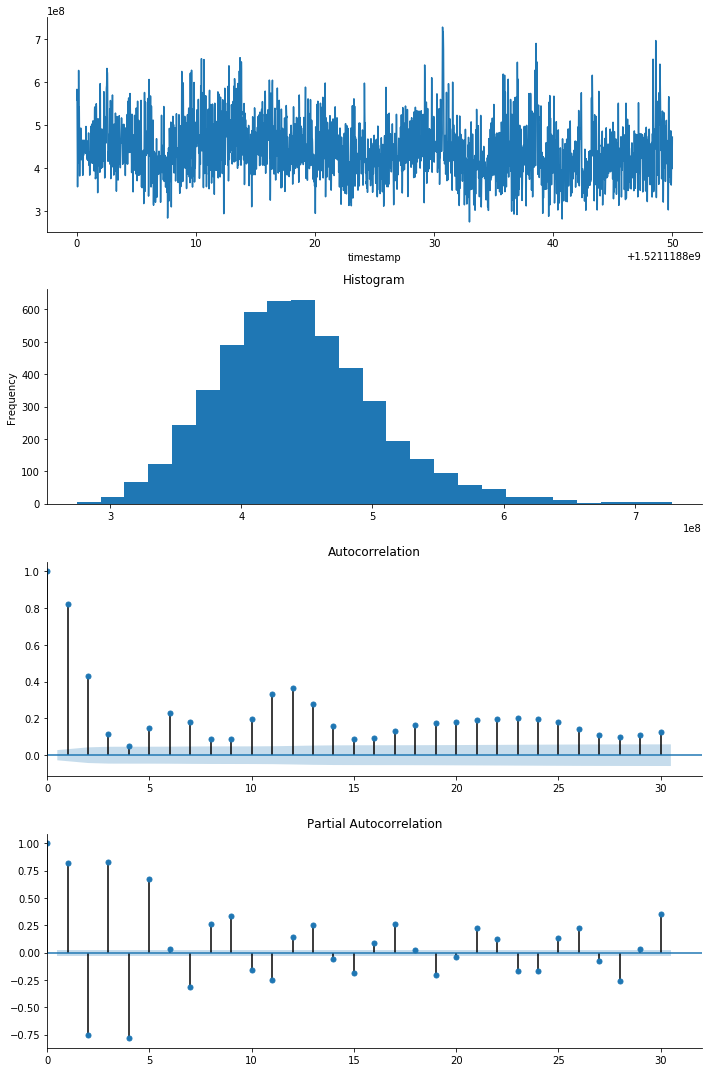

In [71]:
pred=pd.Series(extrapolation,index=data_train.index)
tsplot(pred, lags=30, title='', figsize=(10, 15))

(<matplotlib.axes._subplots.AxesSubplot at 0x246e1098668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246e17f9128>)

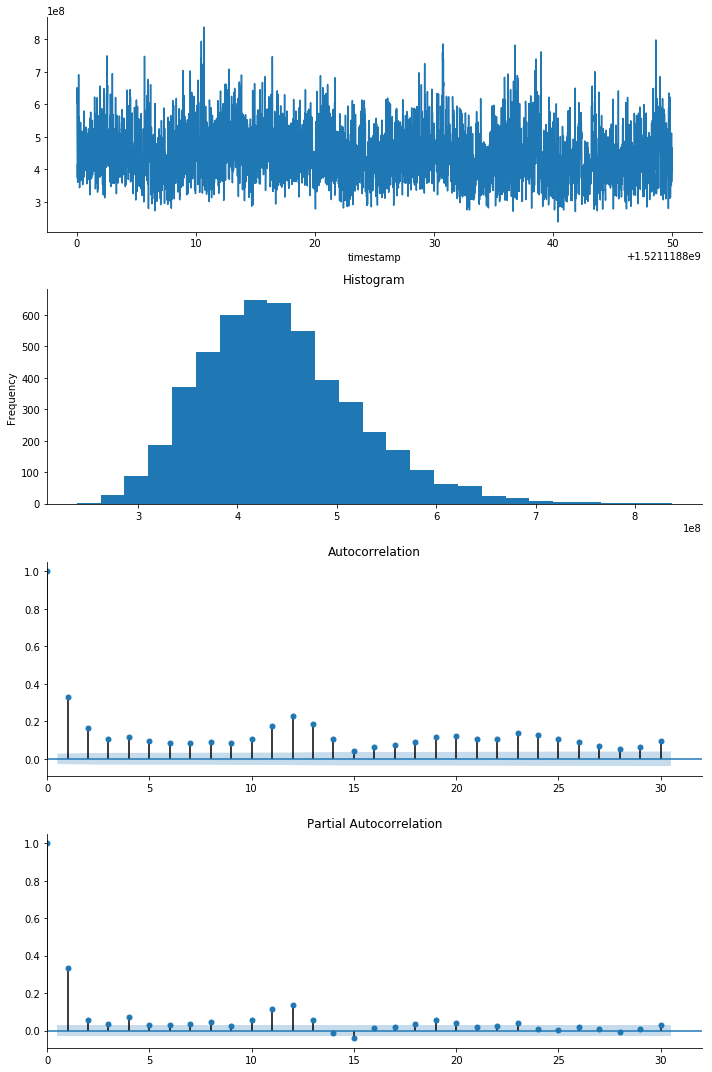

In [72]:
tsplot(data_train, lags=30, title='', figsize=(10, 15))

In [73]:
pred.std(),data_train.std()

(61161441.02594242, 78352547.2513816)

In [74]:
pred.mean(),data_train.mean()

(441816127.72, 441816127.72)

In [184]:
import pywt
len(data_train),len(data_test)

(5000, 1200)

In [255]:
params_train=pywt.dwt(data_train,'db1')
params_test=pywt.dwt(data_test,'db1')

In [256]:
np.array(params_train).shape

(2, 2500)

In [263]:
pred=pywt.idwt(params_train[0],params_train[1],wavelet='db1')

(<matplotlib.axes._subplots.AxesSubplot at 0x246f4ce7588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246f1c6e588>)

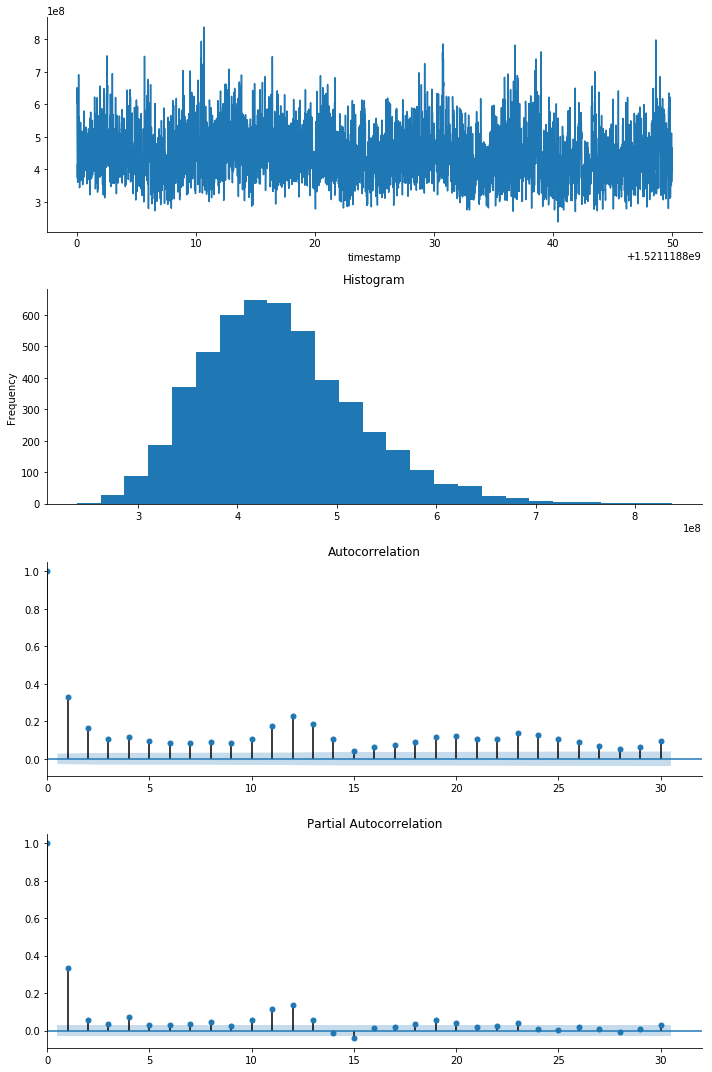

In [264]:
pred1=pd.Series(pred,index=data_train.index)
tsplot(pred1, lags=30, title='', figsize=(10, 15))

In [282]:
data_train_padd=[0,0]
data_train_padd[0]=pywt.pad(params_train[0],250,mode='periodic')
data_train_padd[1]=pywt.pad(params_train[1],250,mode='periodic')


In [283]:
pred=pywt.idwt(data_train_padd[0],data_train_padd[1],wavelet='db1')

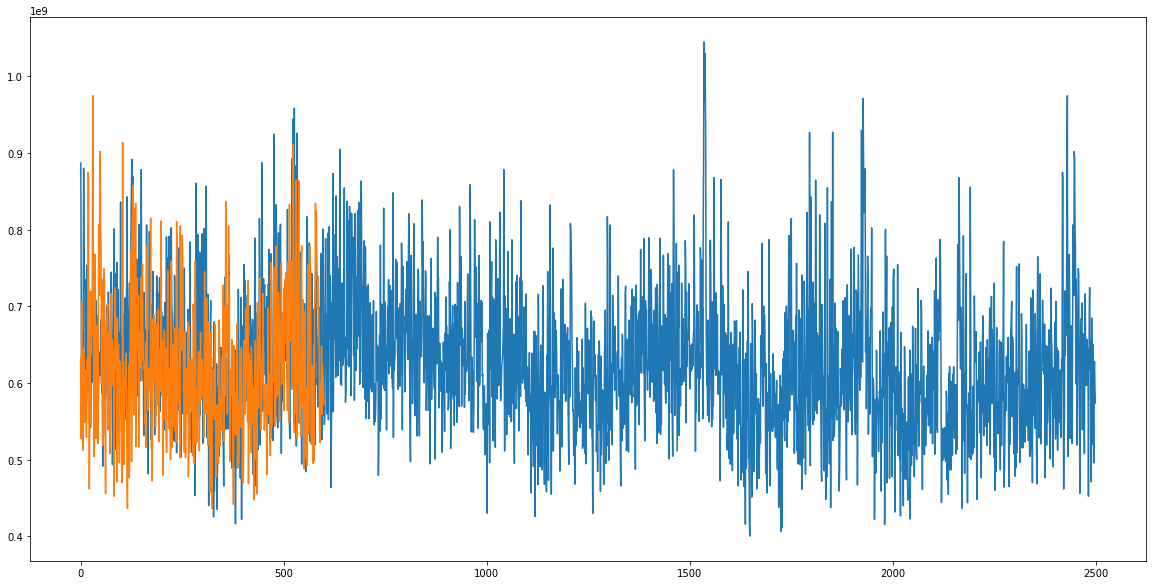

In [284]:
plt.figure(figsize=(20,10))
plt.plot(params_train[0])
plt.plot(params_test[0])

In [244]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries):
    
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries,freq=950)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(30,30))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend , seasonal, residual

(<matplotlib.axes._subplots.AxesSubplot at 0x246efeae0b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246eaaaaac8>)

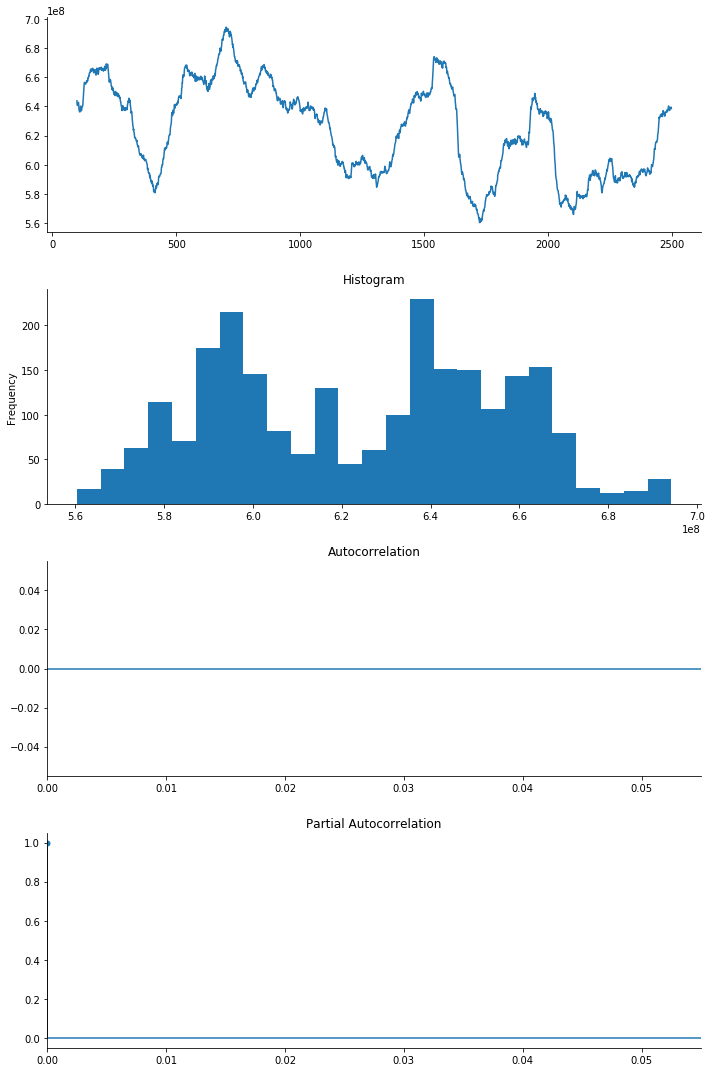

In [221]:
# tsplot(pd.Series(params_train[0]).rolling(window=10).mean(),lags=25)
tsplot(pd.Series(params_train[0]).rolling(window=100).mean(),lags=25)

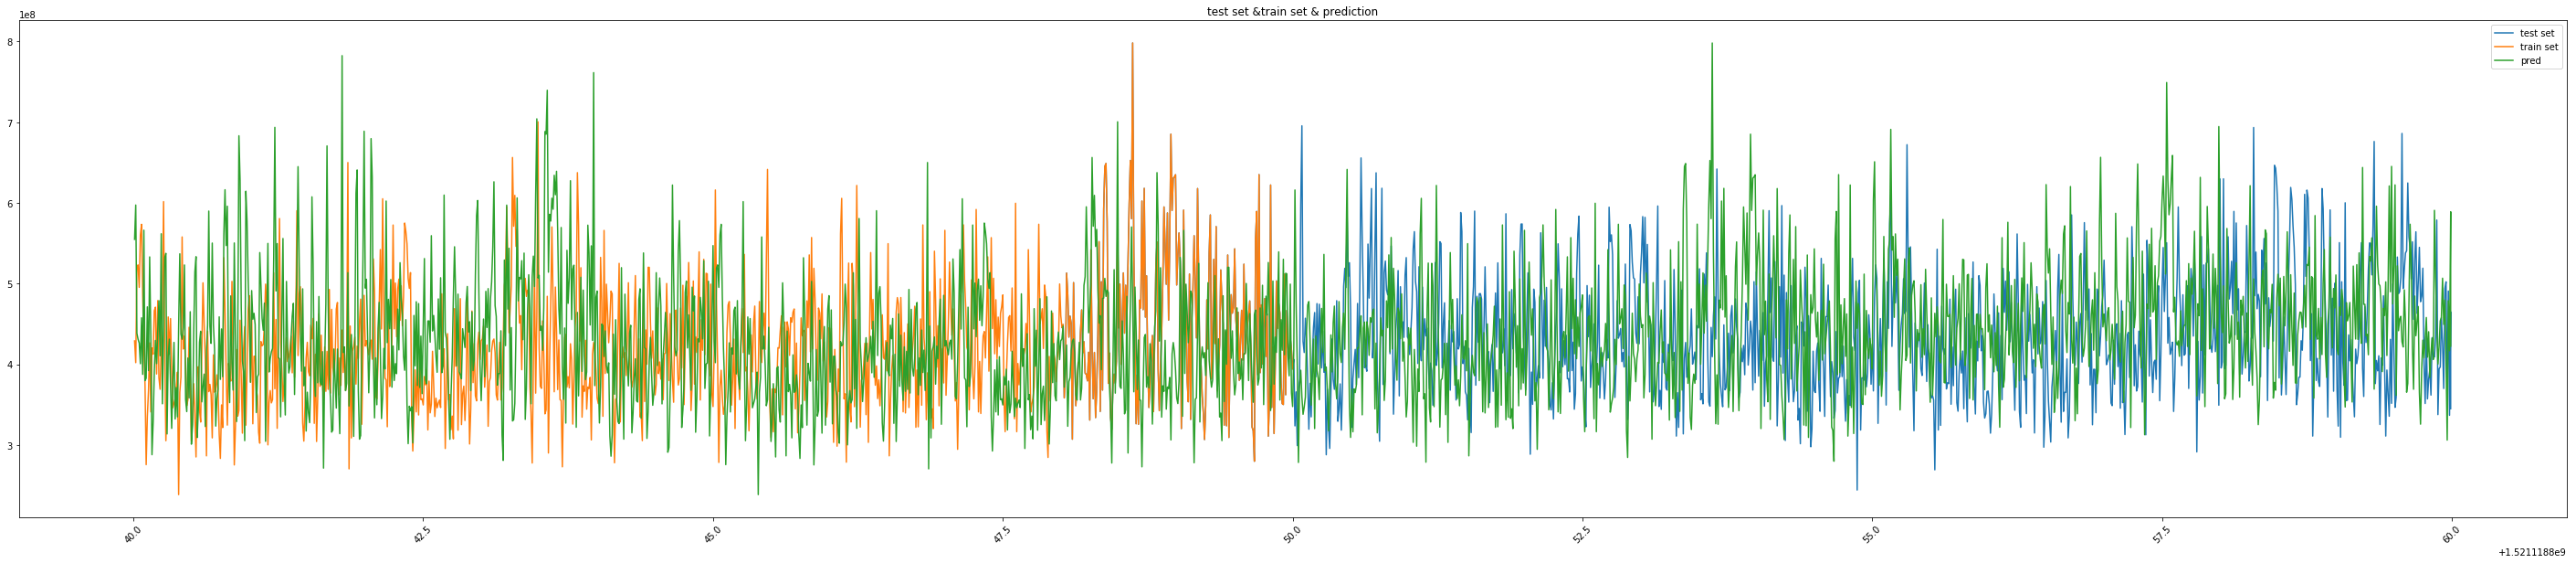

In [287]:
pred=pd.Series(pred,index=data.index)
plt.figure(figsize=(50, 10))
plt.xticks(rotation=45)

plt.plot(data_test)
plt.plot(data_train.iloc[4000:])
plt.plot(pred.iloc[4000:])
plt.legend(["test set","train set","pred"],loc="best")
plt.title("test set &train set & prediction")
plt.savefig("test set &train set & prediction")

(<matplotlib.axes._subplots.AxesSubplot at 0x246fadde748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246f9090668>)

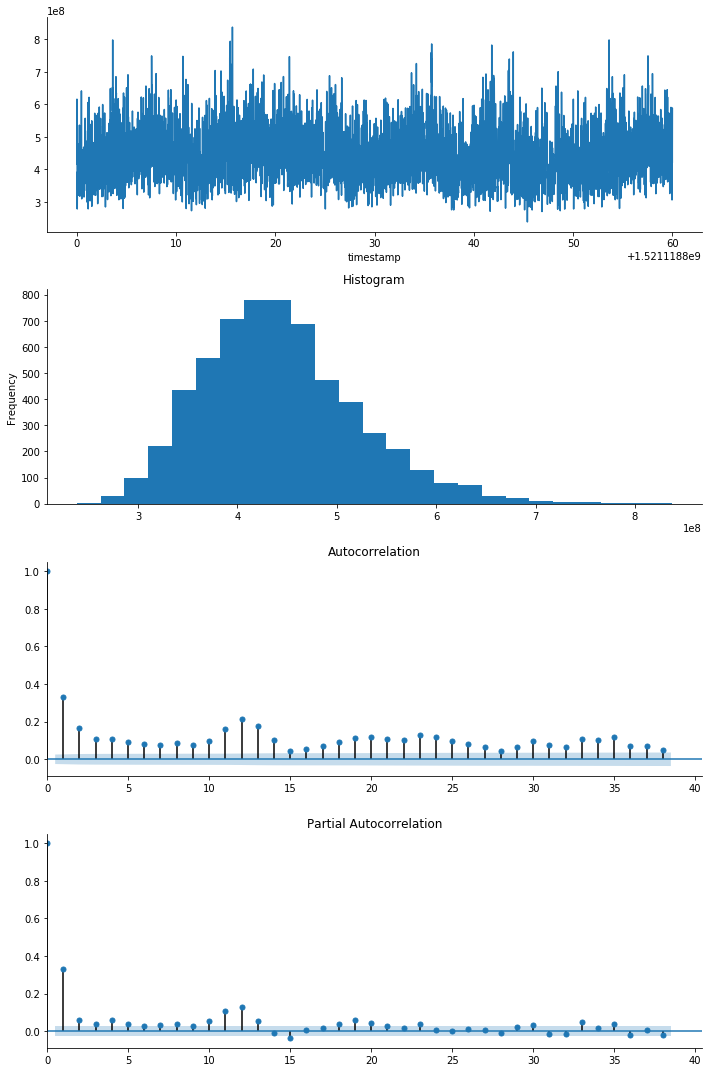

In [288]:
tsplot(pred)

(<matplotlib.axes._subplots.AxesSubplot at 0x246f1a90828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246f3c40668>)

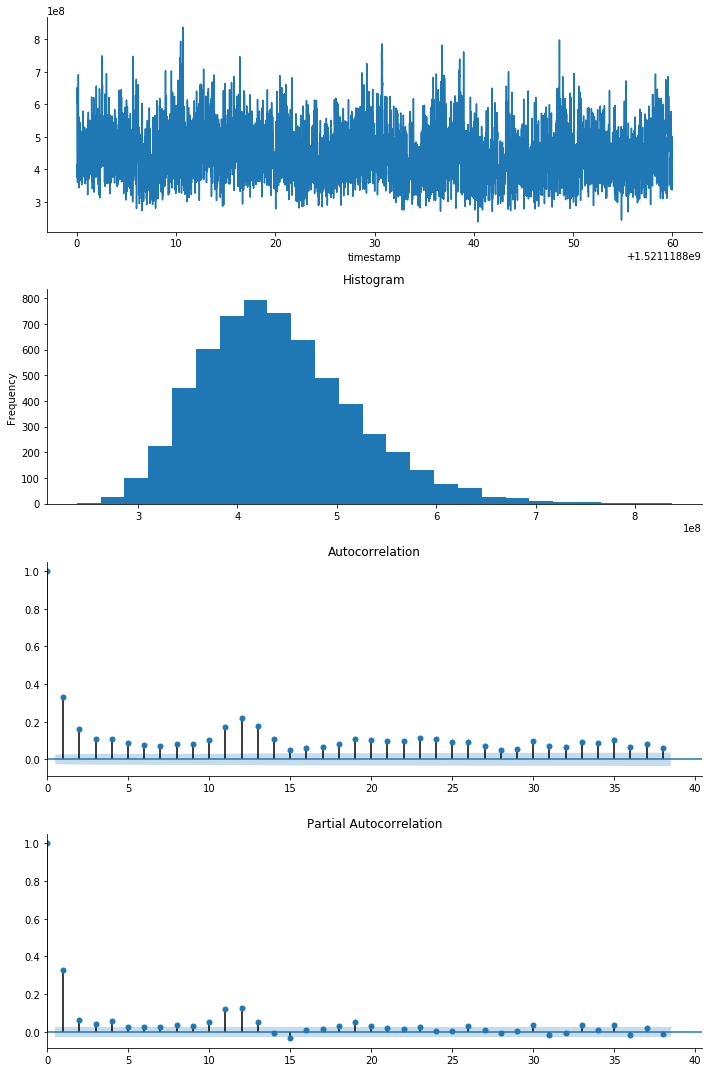

In [289]:
tsplot(data)